In [81]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "trainingdata"

In [82]:
library(recommenderlab)
library(ggplot2)
install.packages(c("recommenderlab", "ggplot2", "data.table", "reshape2"))
library(data.table)
library(reshape2)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“unable to access index for repository http://cran.rstudio.com/src/contrib:
  cannot open URL 'http://cran.rstudio.com/src/contrib/PACKAGES'”
Warning message:
“packages ‘recommenderlab’, ‘ggplot2’, ‘data.table’, ‘reshape2’ are not available for this version of R

Versions of these packages for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


In [83]:
setwd("/kaggle/input/trainingdata")
movie_data <- read.csv("movies.csv",stringsAsFactors=FALSE)
rating_data <- read.csv("ratings.csv")
str(movie_data)

'data.frame':	10329 obs. of  3 variables:
 $ movieId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ title  : chr  "Toy Story (1995)" "Jumanji (1995)" "Grumpier Old Men (1995)" "Waiting to Exhale (1995)" ...
 $ genres : chr  "Adventure|Animation|Children|Comedy|Fantasy" "Adventure|Children|Fantasy" "Comedy|Romance" "Comedy|Drama|Romance" ...


In [84]:
head(movie_data)

,movieId,title,genres
,<int>,<chr>,<chr>
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
6,6,Heat (1995),Action|Crime|Thriller


In [85]:
movie_genre <- as.data.frame(movie_data$genres, stringsAsFactors=FALSE)
library(data.table)
movie_genre2 <- as.data.frame(tstrsplit(movie_genre[,1], '[|]', 
                                   type.convert=TRUE), 
                         stringsAsFactors=FALSE) 
colnames(movie_genre2) <- c(1:10)

list_genre <- c("Action", "Adventure", "Animation", "Children", 
                "Comedy", "Crime","Documentary", "Drama", "Fantasy",
                "Film-Noir", "Horror", "Musical", "Mystery","Romance",
                "Sci-Fi", "Thriller", "War", "Western")
genre_mat1 <- matrix(0,10330,18)
genre_mat1[1,] <- list_genre
colnames(genre_mat1) <- list_genre

for (index in 1:nrow(movie_genre2)) {
  for (col in 1:ncol(movie_genre2)) {
    gen_col = which(genre_mat1[1,] == movie_genre2[index,col]) 
    genre_mat1[index+1,gen_col] <- 1
}
}
genre_mat2 <- as.data.frame(genre_mat1[-1,], stringsAsFactors=FALSE) 
for (col in 1:ncol(genre_mat2)) {
  genre_mat2[,col] <- as.integer(genre_mat2[,col]) 
} 
str(genre_mat2)

'data.frame':	10329 obs. of  18 variables:
 $ Action     : int  0 0 0 0 0 1 0 0 1 1 ...
 $ Adventure  : int  1 1 0 0 0 0 0 1 0 1 ...
 $ Animation  : int  1 0 0 0 0 0 0 0 0 0 ...
 $ Children   : int  1 1 0 0 0 0 0 1 0 0 ...
 $ Comedy     : int  1 0 1 1 1 0 1 0 0 0 ...
 $ Crime      : int  0 0 0 0 0 1 0 0 0 0 ...
 $ Documentary: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Drama      : int  0 0 0 1 0 0 0 0 0 0 ...
 $ Fantasy    : int  1 1 0 0 0 0 0 0 0 0 ...
 $ Film-Noir  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Horror     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Musical    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Mystery    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Romance    : int  0 0 1 1 0 0 1 0 0 0 ...
 $ Sci-Fi     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Thriller   : int  0 0 0 0 0 1 0 0 0 1 ...
 $ War        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Western    : int  0 0 0 0 0 0 0 0 0 0 ...


In [86]:
SearchMatrix <- cbind(movie_data[,1:2], genre_mat2[])
head(SearchMatrix)    

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
5,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,Heat (1995),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [87]:
ratingMatrix <- dcast(rating_data, userId~movieId, value.var = "rating", na.rm=FALSE)
ratingMatrix <- as.matrix(ratingMatrix[,-1]) 
ratingMatrix <- as(ratingMatrix, "realRatingMatrix")
ratingMatrix

668 x 10325 rating matrix of class ‘realRatingMatrix’ with 105339 ratings.

In [88]:
recommendation_model <- recommenderRegistry$get_entries(dataType = "realRatingMatrix")
names(recommendation_model)

[1] "HYBRID_realRatingMatrix"       "ALS_realRatingMatrix"         
 [3] "ALS_implicit_realRatingMatrix" "IBCF_realRatingMatrix"        
 [5] "LIBMF_realRatingMatrix"        "POPULAR_realRatingMatrix"     
 [7] "RANDOM_realRatingMatrix"       "RERECOMMEND_realRatingMatrix" 
 [9] "SVD_realRatingMatrix"          "SVDF_realRatingMatrix"        
[11] "UBCF_realRatingMatrix"

In [89]:
lapply(recommendation_model, "[[", "description")

$HYBRID_realRatingMatrix
[1] "Hybrid recommender that aggegates several recommendation strategies using weighted averages."

$ALS_realRatingMatrix
[1] "Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm."

$ALS_implicit_realRatingMatrix
[1] "Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm."

$IBCF_realRatingMatrix
[1] "Recommender based on item-based collaborative filtering."

$LIBMF_realRatingMatrix
[1] "Matrix factorization with LIBMF via package recosystem (https://cran.r-project.org/web/packages/recosystem/vignettes/introduction.html)."

$POPULAR_realRatingMatrix
[1] "Recommender based on item popularity."

$RANDOM_realRatingMatrix
[1] "Produce random recommendations (real ratings)."

$RERECOMMEND_realRatingMatrix
[1] "Re-recommends highly rated items (real ratings)."

$SVD_realRatingMatrix
[1] "Recommender based on SVD approximation with column-mean imputation."

$SVDF_realRatingMatrix
[1] "Recommender based on Funk SVD with gradient descend (https://sifter.org/~simon/journal/20061211.html)."

$UBCF_realRatingMatrix
[1] "Recommender based on user-based collaborative filtering."

In [90]:
recommendation_model$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

In [116]:
setwd('/kaggle/working')

,1,2,3,4
1,NA,0.9880430,0.9820862,0.9957199
2,0.9880430,NA,0.9962866,0.9687126
3,0.9820862,0.9962866,NA,0.9944484
4,0.9957199,0.9687126,0.9944484,NA


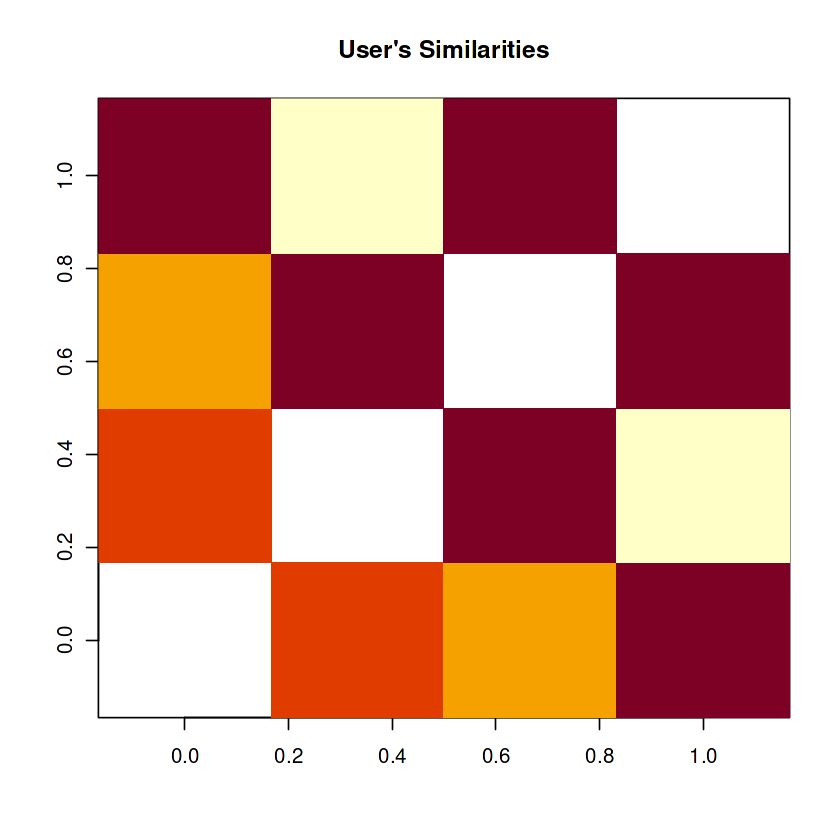

In [117]:
similarity_mat <- similarity(ratingMatrix[1:4, ],
                               method = "cosine",
                               which = "users")
as.matrix(similarity_mat)
image(as.matrix(similarity_mat), main = "User's Similarities")

,1,2,3,4
1,NA,0.9834866,0.9779671,0.9550638
2,0.9834866,NA,0.9829378,0.9706208
3,0.9779671,0.9829378,NA,0.9932438
4,0.9550638,0.9706208,0.9932438,NA


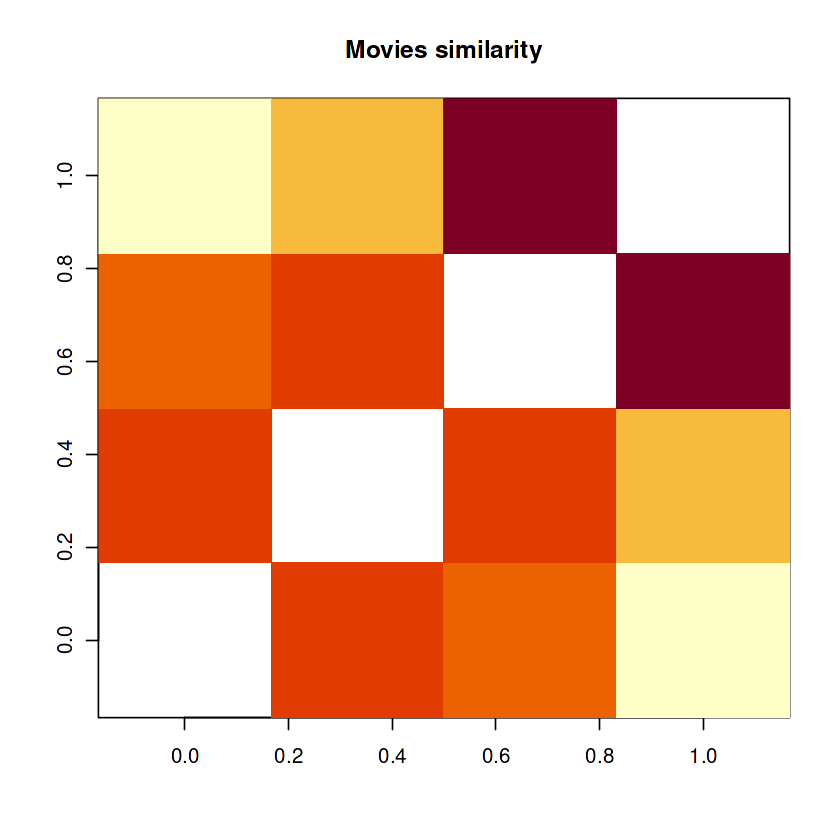

In [93]:
movie_similarity <- similarity(ratingMatrix[, 1:4], method =
                                 "cosine", which = "items")
as.matrix(movie_similarity)
image(as.matrix(movie_similarity), main = "Movies similarity")

In [94]:
rating_values <- as.vector(ratingMatrix@data)
unique(rating_values) 

[1] 0.0 5.0 4.0 3.0 4.5 1.5 2.0 3.5 1.0 2.5 0.5

In [95]:
Table_of_Ratings <- table(rating_values) 
Table_of_Ratings

rating_values
      0     0.5       1     1.5       2     2.5       3     3.5       4     4.5 
6791761    1198    3258    1567    7943    5484   21729   12237   28880    8187 
      5 
  14856 

In [96]:
library(ggplot2)
movie_views <- colCounts(ratingMatrix) 
table_views <- data.frame(movie = names(movie_views),
                          views = movie_views) 
table_views <- table_views[order(table_views$views,
                                 decreasing = TRUE), ]
table_views$title <- NA
for (index in 1:10325){
  table_views[index,3] <- as.character(subset(movie_data,
                                         movie_data$movieId == table_views[index,1])$title)
}
table_views[1:6,]

,movie,views,title
,<chr>,<int>,<chr>
296,296,325,Pulp Fiction (1994)
356,356,311,Forrest Gump (1994)
318,318,308,"Shawshank Redemption, The (1994)"
480,480,294,Jurassic Park (1993)
593,593,290,"Silence of the Lambs, The (1991)"
260,260,273,Star Wars: Episode IV - A New Hope (1977)


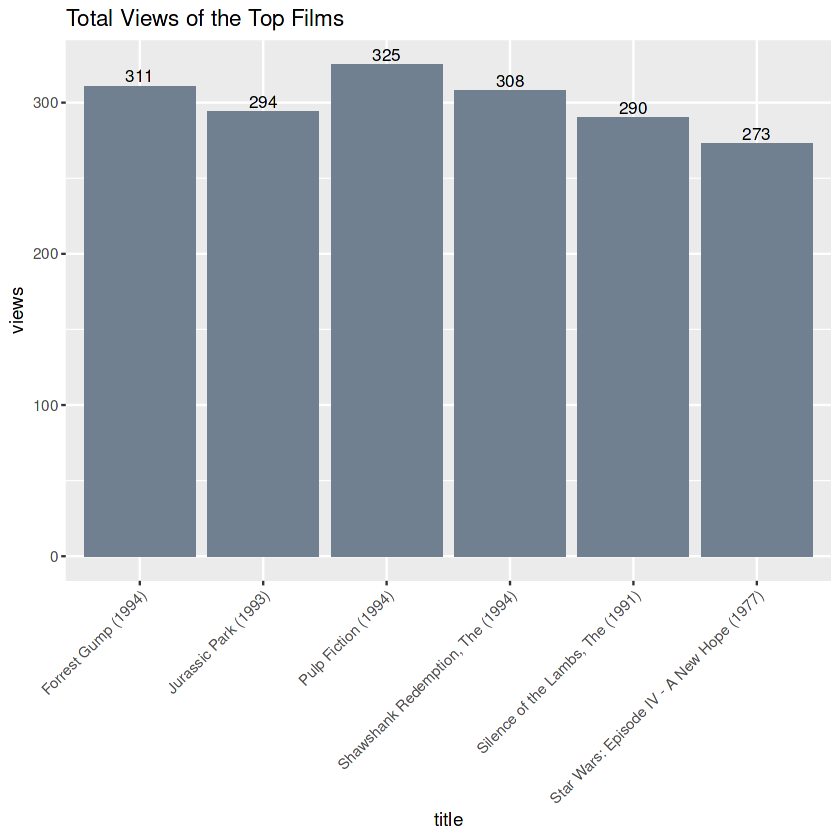

In [97]:
ggplot(table_views[1:6, ], aes(x = title, y = views)) +
  geom_bar(stat="identity", fill = 'slategrey') +
  geom_text(aes(label=views), vjust=-0.3, size=3.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +

  ggtitle("Total Views of the Top Films")

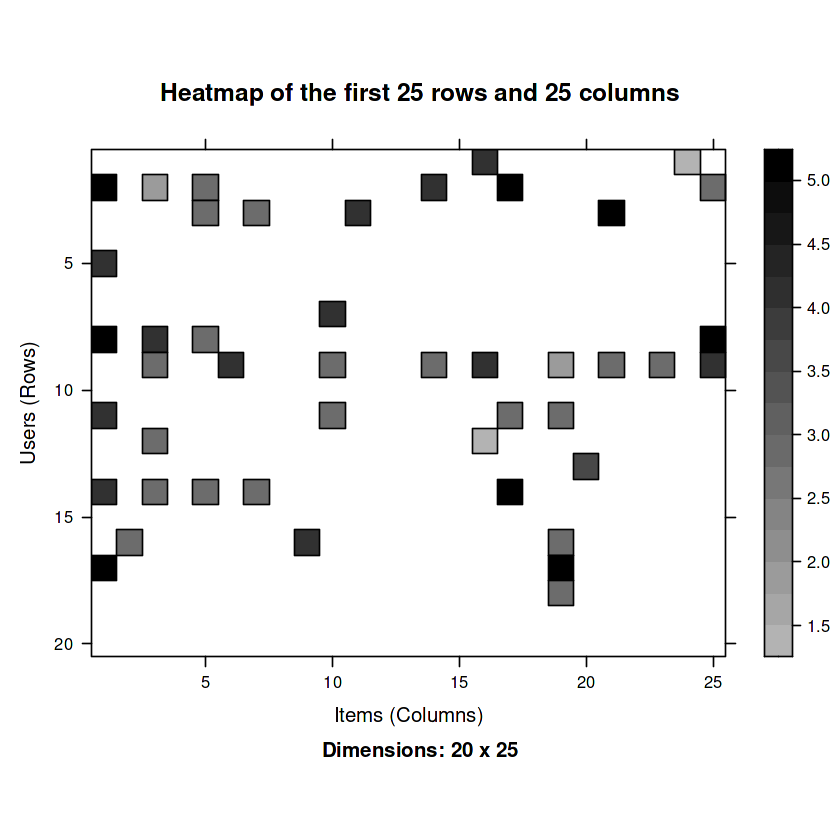

In [98]:
image(ratingMatrix[1:20, 1:25], axes = FALSE, main = "Heatmap of the first 25 rows and 25 columns")

In [99]:
movie_ratings <- ratingMatrix[rowCounts(ratingMatrix) > 50,
                             colCounts(ratingMatrix) > 50]
movie_ratings

420 x 447 rating matrix of class ‘realRatingMatrix’ with 38341 ratings.

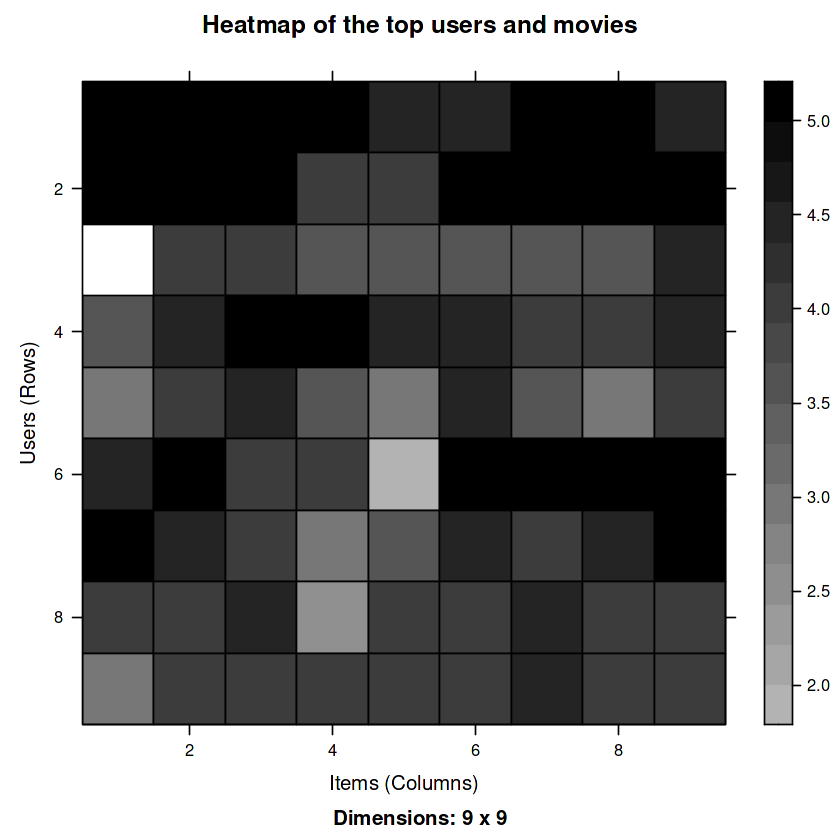

In [100]:
minimum_movies<- quantile(rowCounts(movie_ratings), 0.98)
minimum_users <- quantile(colCounts(movie_ratings), 0.98)
image(movie_ratings[rowCounts(movie_ratings) > minimum_movies,
                     colCounts(movie_ratings) > minimum_users],
main = "Heatmap of the top users and movies")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



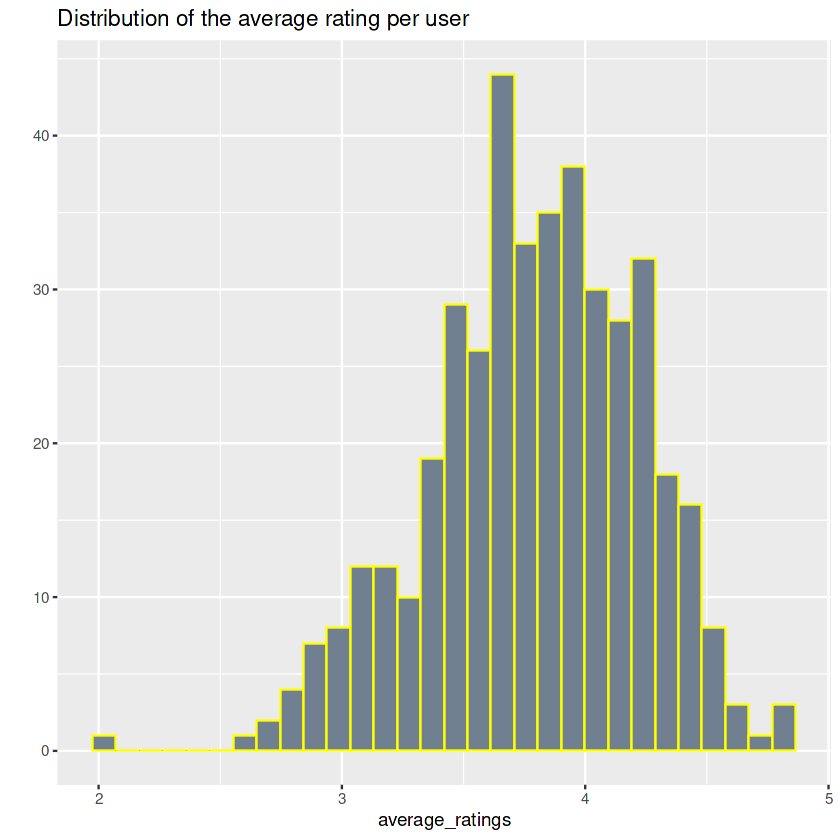

In [101]:
average_ratings <- rowMeans(movie_ratings)
qplot(average_ratings, fill=I("slategrey"), col=I("yellow")) +
  ggtitle("Distribution of the average rating per user")

[1] 0

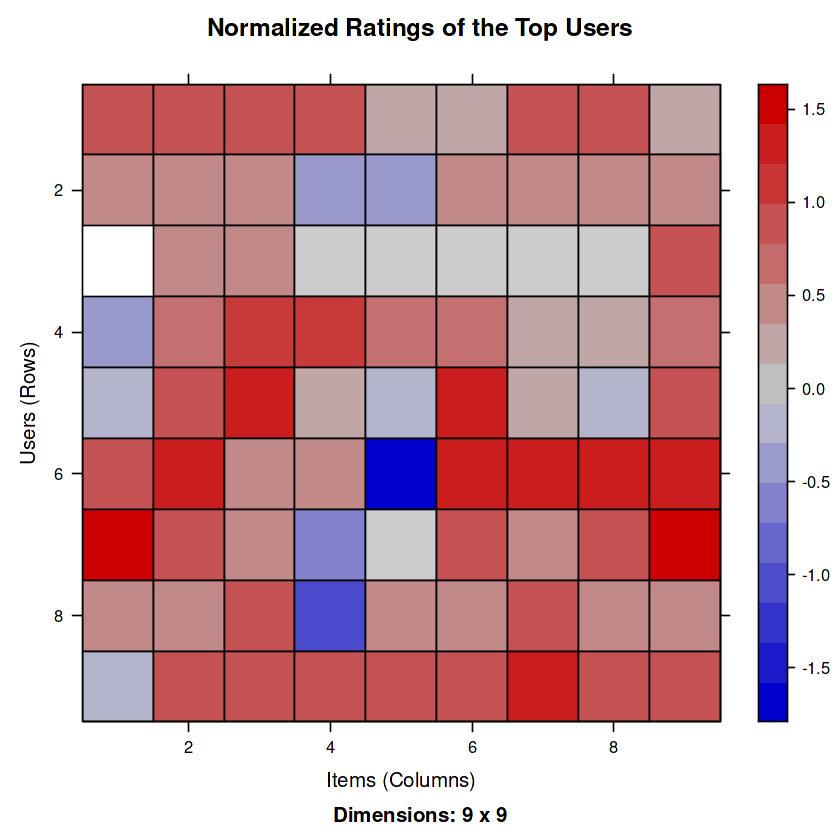

In [102]:
normalized_ratings <- normalize(movie_ratings)
sum(rowMeans(normalized_ratings) > 0.00001)

image(normalized_ratings[rowCounts(normalized_ratings) > minimum_movies,
                          colCounts(normalized_ratings) > minimum_users],
main = "Normalized Ratings of the Top Users")

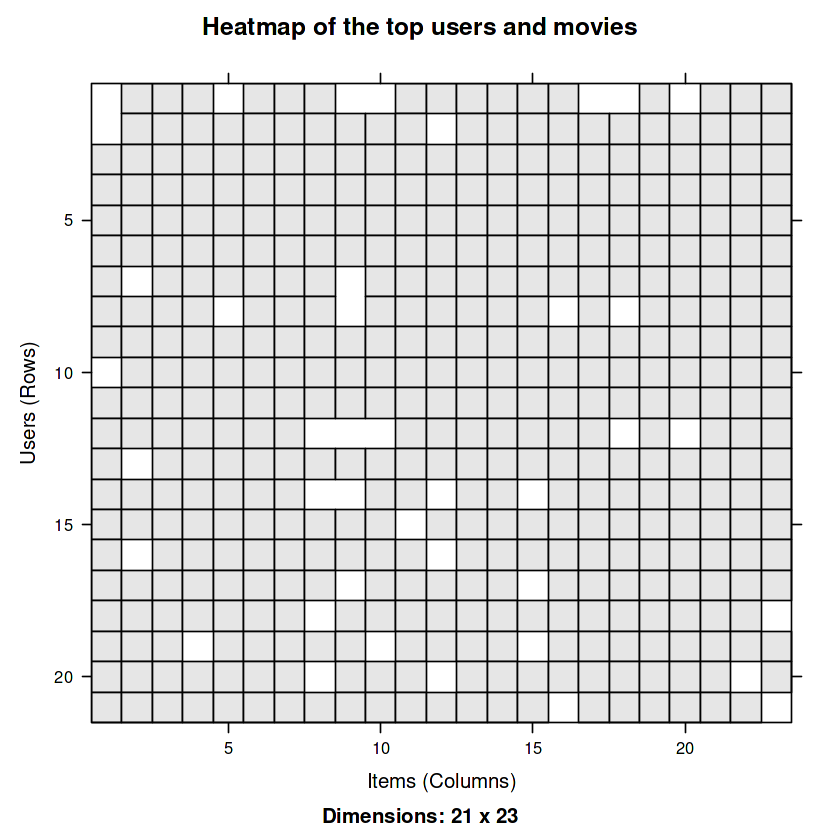

In [103]:
binary_minimum_movies <- quantile(rowCounts(movie_ratings), 0.95)
binary_minimum_users <- quantile(colCounts(movie_ratings), 0.95)
movies_watched <- binarize(movie_ratings, minRating = 1)

good_rated_films <- binarize(movie_ratings, minRating = 3)
image(good_rated_films[rowCounts(movie_ratings) > binary_minimum_movies,
colCounts(movie_ratings) > binary_minimum_users],
main = "Heatmap of the top users and movies")

In [104]:
sampled_data<- sample(x = c(TRUE, FALSE),
                      size = nrow(movie_ratings),
                      replace = TRUE,
                      prob = c(0.8, 0.2))
training_data <- movie_ratings[sampled_data, ]
testing_data <- movie_ratings[!sampled_data, ]

In [105]:
recommendation_system <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommendation_system$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

In [106]:
recommen_model <- Recommender(data = training_data,
                          method = "IBCF",
                          parameter = list(k = 30))
recommen_model
class(recommen_model)

Recommender of type ‘IBCF’ for ‘realRatingMatrix’ 
learned using 335 users.

[1] "Recommender"
attr(,"package")
[1] "recommenderlab"

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1] 447 447

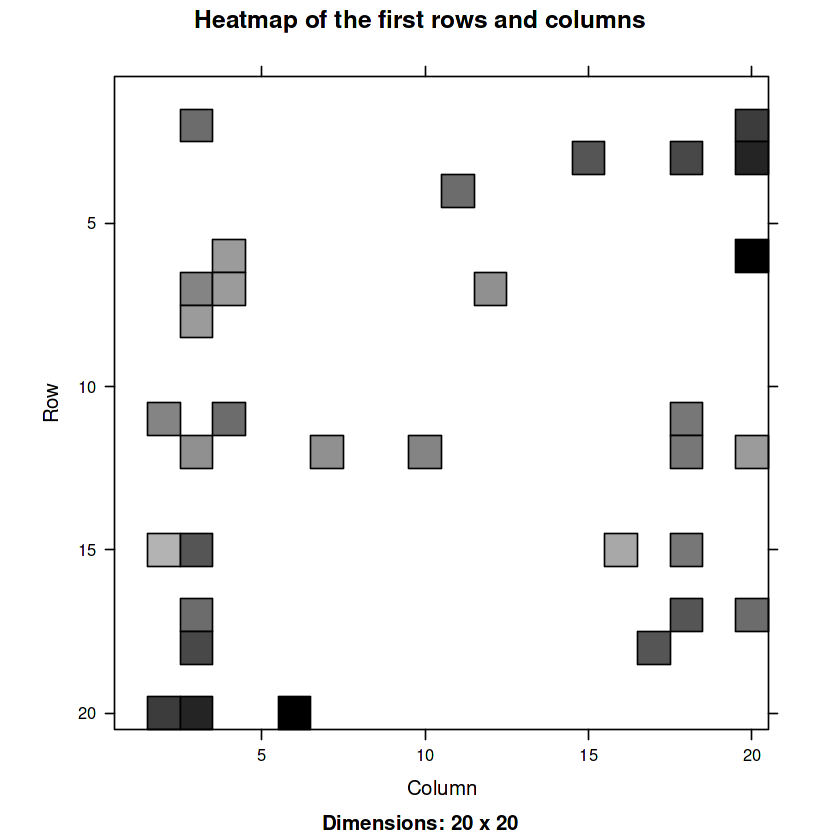

In [107]:
model_info <- getModel(recommen_model)
class(model_info$sim)
dim(model_info$sim)
top_items <- 20
image(model_info$sim[1:top_items, 1:top_items],
   main = "Heatmap of the first rows and columns")

sum_rows
 30 
447 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



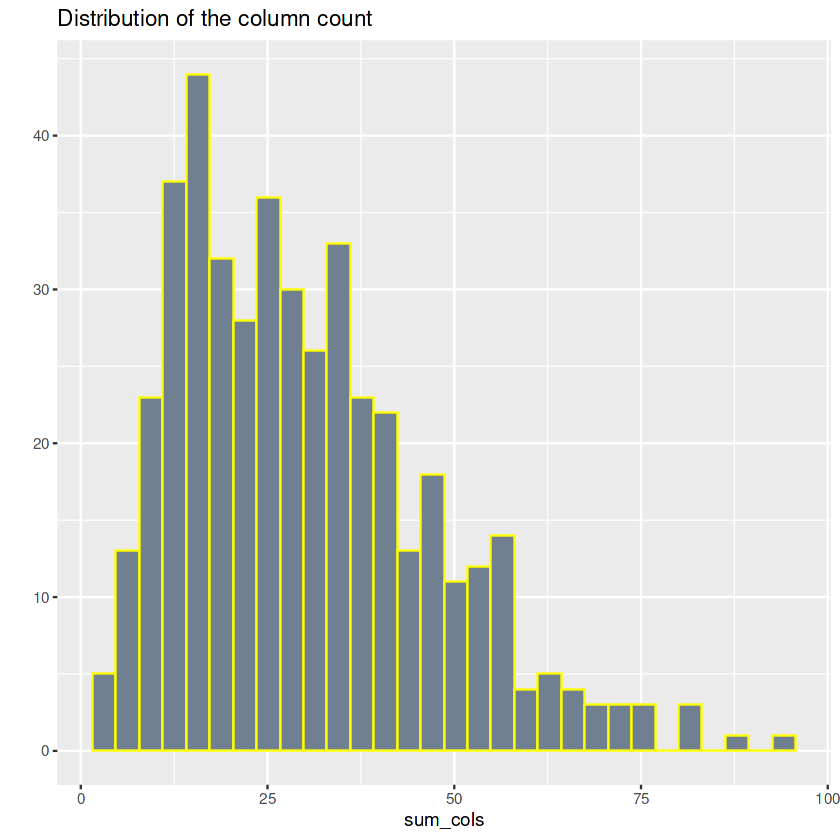

In [108]:
sum_rows <- rowSums(model_info$sim > 0)
table(sum_rows)

sum_cols <- colSums(model_info$sim > 0)
qplot(sum_cols, fill=I("slategrey"), col=I("yellow"))+ ggtitle("Distribution of the column count")

In [109]:
top_recommendations <- 10 
predicted_recommendations <- predict(object = recommen_model,
                          newdata = testing_data,
                          n = top_recommendations)
predicted_recommendations

Recommendations as ‘topNList’ with n = 10 for 85 users. 

In [110]:
user1 <- predicted_recommendations@items[[1]]
movies_user1 <- predicted_recommendations@itemLabels[user1]
movies_user2 <- movies_user1
for (index in 1:10){
  movies_user2[index] <- as.character(subset(movie_data,
                                         movie_data$movieId == movies_user1[index])$title)
}
movies_user2

[1] "Dead Man Walking (1995)"                                   
 [2] "Ed Wood (1994)"                                            
 [3] "Like Water for Chocolate (Como agua para chocolate) (1992)"
 [4] "Natural Born Killers (1994)"                               
 [5] "Quiz Show (1994)"                                          
 [6] "Stargate (1994)"                                           
 [7] "Four Weddings and a Funeral (1994)"                        
 [8] "True Lies (1994)"                                          
 [9] "Robin Hood: Men in Tights (1993)"                          
[10] "James and the Giant Peach (1996)"

In [111]:
recommendation_matrix <- sapply(predicted_recommendations@items,
                      function(x){ as.integer(colnames(movie_ratings)[x]) }) 
dim(recommendation_matrix)
recommendation_matrix[,1:4]

[1] 10 85

0,1,2,3
36,3,150,1203
235,39,1674,5618
265,50,588,2692
288,110,474,62
300,158,3000,1304
316,266,55820,1234
357,293,555,1258
380,318,60069,1732
520,349,4973,2329
661,380,1961,1204


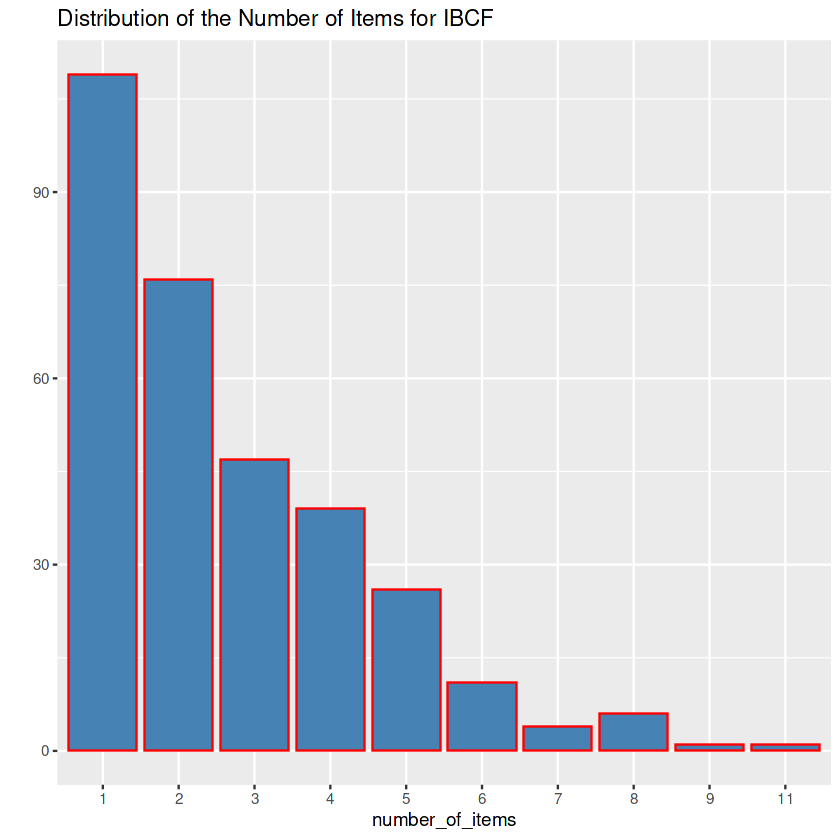

In [112]:
number_of_items <- factor(table(recommendation_matrix))
chart_title <- "Distribution of the Number of Items for IBCF"
qplot(number_of_items, fill=I("steelblue"), col=I("red")) + ggtitle(chart_title)

In [113]:
number_of_items_sorted <- sort(number_of_items, decreasing = TRUE)
number_of_items_top <- head(number_of_items_sorted, n = 4)
table_top <- data.frame(as.integer(names(number_of_items_top)),
number_of_items_top)
for(i in 1:4) {
table_top[i,1] <- as.character(subset(movie_data,
movie_data$movieId == table_top[i,1])$title)
}

colnames(table_top) <- c("Movie Title", "No. of Items")
head(table_top)

,Movie Title,No. of Items
,<chr>,<fct>
161,Crimson Tide (1995),11
919,"Wizard of Oz, The (1939)",9
25,Leaving Las Vegas (1995),8
110,Braveheart (1995),8
